First, read in the data and check out the columns:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
fpp_all = pd.read_csv('fpp_final_table.csv', index_col=0)
fpp_all.count()

koi.1                    8826
rprs                     8440
secthresh                8440
maxrad                   8440
pr_heb                   8016
pr_eb                    8016
pr_beb                   8016
L_tot                    8145
fp                       8145
FPP                      8016
kepid                    8826
period                   8826
rp                       8321
disposition              8826
prob_ontarget            6787
pos_prob_score           7470
not_transitlike          8826
significant_secondary    8826
centroid_offset          8826
ephem_match              8826
exception                 681
has_ttv                  8556
dtype: int64

Now, we want to split up this whole population into distinct subsets, based on sequential categorizations, in the following order:

* Archive disposition (based on the cumulative table). CONFIRMED and FALSE POSITIVE are their own category; CANDIDATE gets further subdivided.  
* Whether the `vespa` calculation worked or not.
* Whether positional probability calculation is reliable (based on `prob_score_thresh`).  Unreliable goes into "uncertain" category; 
* Reliable positional probs gets further divided based on prob > 0.99 or not.
* Positional prob > 0.99 gets further divided by FPP.  The "validated" subset is the subset of these with FPP < 0.01

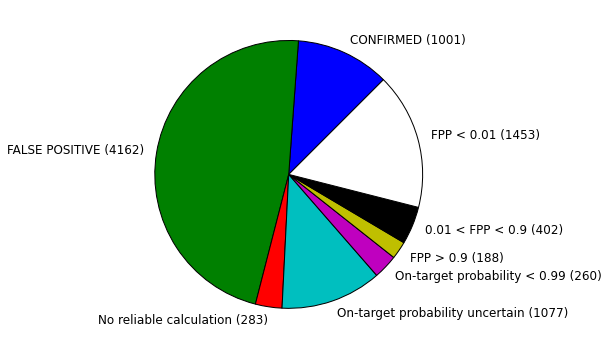

In [2]:
prob_score_thresh = 0.3

confirmed = fpp_all['disposition'] == 'CONFIRMED'
known_fp = fpp_all['disposition'] == 'FALSE POSITIVE'
candidate = fpp_all['disposition'] == 'CANDIDATE'
low_fpp = fpp_all['FPP'] < 0.01
hi_fpp = fpp_all['FPP'] > 0.9
med_fpp = (fpp_all['FPP'] >= 0.01) & (fpp_all['FPP'] <=0.9)
on_target = (fpp_all['prob_ontarget'] >= 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
off_target = (fpp_all['prob_ontarget'] < 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
target_ambiguous = ((fpp_all['pos_prob_score'] < prob_score_thresh) | 
                    np.isnan(fpp_all['pos_prob_score']) | 
                    np.isnan(fpp_all['prob_ontarget']))
not_crazy = fpp_all['L_tot'] > 1e-3
crazy = fpp_all['L_tot'] <= 1e-3

fpp_calculated = np.isfinite(fpp_all['FPP']) #whether FPP calculation worked

##Just some checks to see if things add up properly
#reliable = (confirmed | candidate) & on_target & not_crazy
#print(sum(reliable))
#print(sum(reliable & low_fpp))
#print(sum(candidate & on_target & not_crazy & low_fpp))
#print(sum(confirmed))
#print(sum(candidate & high_fpp))
#print(sum(confirmed & high_fpp))

newfp = (candidate & fpp_calculated & not_crazy & on_target & hi_fpp)
newmed = (candidate & fpp_calculated & not_crazy & on_target & med_fpp)
newval = (candidate & fpp_calculated & not_crazy & on_target & low_fpp)

categories = [ confirmed, known_fp, 
              (candidate & ~fpp_calculated) | (candidate & fpp_calculated & crazy),
              (candidate & fpp_calculated & not_crazy & target_ambiguous),
              (candidate & fpp_calculated & not_crazy & off_target),
              newfp, newmed, newval]

labels = ['CONFIRMED ({})'.format(categories[0].sum()),
          'FALSE POSITIVE ({})'.format(categories[1].sum()),
          'No reliable calculation ({})'.format(categories[2].sum()),
          'On-target probability uncertain ({})'.format(categories[3].sum()),
          'On-target probability < 0.99 ({})'.format(categories[4].sum()), 
          'FPP > 0.9 ({})'.format(categories[5].sum()), 
          '0.01 < FPP < 0.9 ({})'.format(categories[6].sum()), 
          'FPP < 0.01 ({})'.format(categories[7].sum())]

needmore = categories[2] | categories[3] | categories[4]

sums = np.array([c.sum() for c in categories])
fracs = sums / float(sums.sum()) * 100

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pie(fracs, labels=labels, startangle=45);